In [10]:
import pandas as pd
import numpy as np
from datetime import *
import networkx as nx
from collections import *
from tqdm.notebook import tqdm

import dask
from multiprocessing.dummy import Pool
import multiprocessing
import matplotlib.pyplot as plt
import networkx.drawing
import pickle

In [2]:
def dateparse(time_as_a_unix_timestamp):
    return pd.to_datetime(time_as_a_unix_timestamp, unit="s").strftime("%Y-%m-%d %H:%M")

In [3]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## 1. Data

In [4]:
#Answers to questions
a2q = pd.read_csv("sx-stackoverflow-a2q.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)

#Comments to answers
c2a = pd.read_csv("sx-stackoverflow-c2a.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)

#Comments to questions
c2q = pd.read_csv("sx-stackoverflow-c2q.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)

In the merged graph we have weighted link and we have decided to build these weights in the following way:
-  we have assigned a score of 1.0 to "Answers to questions"
-  we have assigned a score of 0.7 to "Comments to questions"
-  we have assigned a score of 0.4 to "Comments to answers"

The reasons are that we have thought that the answers to questions are the more relevant in the merged graph because they are possible solutions of user's question. Then a bit less important are comments to questions, but they could be relevant to clarify the question or specify something. Comments to answer are the least relevant, but we have not wanted to penalize them too much because in some situations they could be useful.

In [5]:
#Answers to questions
a2q["weights"] = 1

#Comments to answers
c2a["weights"] = 0.4

#Comments to questions
c2q["weights"] = 0.7

Nice and simultaneous visualization of the three file!

In [6]:
display("a2q", "c2a", "c2q")

,user_a,user_b,time,weights
0,9,8,2008-08-01 05:17:00,1
1,1,1,2008-08-01 06:56:00,1
2,13,1,2008-08-01 15:57:00,1
3,17,1,2008-08-01 19:07:00,1
4,48,2,2008-08-01 19:16:00,1
...,...,...,...,...
17823520,2773607,1048138,2016-03-06 12:16:00,1
17823521,6018278,1982354,2016-03-06 12:16:00,1
17823522,3187183,1404306,2016-03-06 12:17:00,1
17823523,6022341,1667278,2016-03-06 12:17:00,1


In [186]:
totDataframe = pd.concat([a2q, c2a, c2q])
totDataframe

,user_a,user_b,time,weights
0,9,8,2008-08-01 05:17:00,1.0
1,1,1,2008-08-01 06:56:00,1.0
2,13,1,2008-08-01 15:57:00,1.0
3,17,1,2008-08-01 19:07:00,1.0
4,48,2,2008-08-01 19:16:00,1.0
...,...,...,...,...
20268146,1177890,4917254,2016-03-06 14:06:00,0.7
20268147,3345375,4022289,2016-03-06 14:08:00,0.7
20268148,3507137,1801524,2016-03-06 14:09:00,0.7
20268149,5617035,4368648,2016-03-06 14:10:00,0.7


In [11]:
totDataframe_2y = totDataframe[totDataframe.time.between("2015","2017")]
a2q_2y = a2q[a2q.time.between("2015","2017")]
c2q_2y = c2q[c2q.time.between("2015","2017")]
c2a_2y = c2a[c2a.time.between("2015","2017")]
display("a2q_2y", "c2a_2y", "c2q_2y", "totDataframe_2y")

,user_a,user_b,time,weights
14055617,335858,1045881,2015-01-01 00:00:00,1
14055618,3829874,3829874,2015-01-01 00:00:00,1
14055619,315228,3849055,2015-01-01 00:01:00,1
14055620,2182521,2182521,2015-01-01 00:01:00,1
14055621,3047078,4059893,2015-01-01 00:01:00,1
...,...,...,...,...
17823520,2773607,1048138,2016-03-06 12:16:00,1
17823521,6018278,1982354,2016-03-06 12:16:00,1
17823522,3187183,1404306,2016-03-06 12:17:00,1
17823523,6022341,1667278,2016-03-06 12:17:00,1


In [12]:
totDataframe_2y[totDataframe_2y.time.between("2015-01-01","2015-01-01")].iloc[:1000]

,user_a,user_b,time,weights
14055617,335858,1045881,2015-01-01,1.0
14055618,3829874,3829874,2015-01-01,1.0
19731113,3516348,3516348,2015-01-01,0.4
19731114,2138993,2138993,2015-01-01,0.4
19731115,3040948,3040948,2015-01-01,0.4
19731116,307339,1115059,2015-01-01,0.4
14184111,34397,4322629,2015-01-01,0.7
14184112,176075,3931833,2015-01-01,0.7
14184113,180329,180329,2015-01-01,0.7
14184114,1577580,8741,2015-01-01,0.7


In [8]:
class EDGE:
    
    def __init__(self, from_n, to_n, time, w):
        self.from_n = from_n
        self.to_n = to_n
        self.w = w
        self.time = time
        
    def __repr__(self):
        return f"{self.from_n} -> {self.to_n} ::::: weight = {self.w} ::::: time: {self.time}"

In [62]:
class GRAPH:
    
    def __init__(self, nodes = [], edges = []):
        self.nodes = defaultdict(list, {k:[] for k in nodes})
        
        if(len(edges)>0):
            for edge in tqdm(edges):
                self.nodes[edge.from_n].append(edge)
                self.nodes[edge.to_n].append(edge)
        
        self.num_nodes = len(nodes)
        self.num_edges = len(edges)
        self.visited = []
        
    def add_node(self, node):
        self.nodes[node] = self.nodes.get(node, [])
        
    def add_edge(self, from_n, to_n, time, w):
        e = EDGE(from_n, to_n, time, w)
        
        self.nodes[from_n].append(e)
        self.nodes[to_n].append(e)
        
    def add_edge_object(self, edge):
        
        self.nodes[edge.from_n].append(edge)
        self.nodes[edge.to_n].append(edge)
        
    def add_edge_object_list(self, edges):
        
        for edge in edges:
            self.nodes[edge.from_n].append(edge)
            self.nodes[edge.to_n].append(edge)
            
    def get_edge(self, from_n, to_n):
        out_edge = None
        for edge in self.nodes[from_n]:
            if(edge.from_n == from_n and edge.to_n == to_n):
                out_edge = edge
        return out_edge
    
    def delete_edge(self, from_n, to_n):
        for edge in self.nodes[from_n]:
            if(edge.from_n == from_n and edge.to_n == to_n):
                self.nodes[from_n].remove(edge)
                
        for edge in self.nodes[to_n]:
            if(edge.from_n == from_n and edge.to_n == to_n):
                self.nodes[to_n].remove(edge)
                
    def delete_all_edge_of_node(self, node):
        for edge in self.nodes[node]:
    
            if(edge.to_n != node):
                self.nodes[edge.to_n].remove(edge)
                
             
            else:
                self.nodes[edge.from_n].remove(edge)
        
        self.nodes[node] = []
             

            
            
    def is_linked_from(self, node_a, node_b):
        return node_a in [n.from_n for n in self.nodes[node_b]]
    
    def is_linked_to(self, node_a, node_b):
        return node_a in [n.to_n for n in self.nodes[node_b]]
    
    def is_visited(self, node):
        return node in self.visited
            
    def clear_graph_path(self):
        self.visited = []
        
    def print_graph(self, size = (7,7)):
        G = nx.DiGraph()
        for k in tqdm(self.nodes):
            G.add_weighted_edges_from([(el.from_n, el.to_n, el.w) for el in self.nodes[k]])
            
        plt.figure(figsize=size)
        pos = nx.random_layout(G)
        nx.draw(G, pos, with_labels=True, font_weight='bold')

        labels = nx.get_edge_attributes(G, name="weight")
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels);
        plt.savefig("test.pdf")
        plt.show()
        
    
    def __repr__(self):
        return f"{self.nodes}"
    
    def __len__(self):
        return len(self.nodes)

## Functionality 1 - Get the overall features of the graph

In [12]:
#array of nodes of graph a2q
nodi_grafo = pd.concat([a2q["user_a"], a2q["user_b"]], axis = 0).drop_duplicates().array


In [13]:
edge_grafo = []
for i in range(len(a2q)): 
    edge_grafo.append(EDGE(a2q.iloc[i,0],a2q.iloc[i,1], a2q.iloc[i,2], a2q.iloc[i,3]))

In [14]:
#creation of the graph a2q
a2q_graph = GRAPH(nodi_grafo, edge_grafo)

In [15]:
#Number of users
num_node = a2q_graph.num_nodes
num_node

2464606

In [ ]:
num_edge = a2q_graph.num_edge

In [ ]:
number_nodes, number_edges, directed, mean, density = fun_1.functionality(a2q)

In [75]:
end = 0
while (end == 0):
    
    user = int(input("Welcome user, what functionality do you want: "))
    
    if (user == 1):
        
        print("Functionality 1 - Get the overall features of the graph")
        print("The a2q is: " + directed)
        print("Number of users: " +str(number_node))
        print("Number of answers: " +str(number_edge))
        print("Average number of links per user is: " + str(mean))
        print(f"The graph density is: {density}, so the graph is sparse")
        
        end = 1
        
    if (user == 2):
        
        print("result of func_2")
        print("Functionality 2 - Find the best users!")
        end = 1
        
    if (user == 3):
        print("Functionality 3 - Shortest Ordered Route")
        print("result of func_3")
        end = 1


Welcome user, what functionality do you want: 2
result of func_2
Functionality 2 - Find the best users!


In [26]:
p_start

2322630

In [27]:
p_end

4557888

In [ ]:
def functionality_3(start_time, end_time, p, p_1, p_n):

In [ ]:
def grafo(df): 
    #list of nodes
    nodi_grafo = pd.concat([df["user_a"], df["user_b"]], axis = 0).drop_duplicates().array
    
    #list of edges 
    edge_grafo = []
    
    #read each row of the dataframe
    for i in range(len(df)): 
        
        #exploit the class edge to create them
        edge_grafo.append(EDGE(df.iloc[i,0], df.iloc[i,1], df.iloc[i,2], df.iloc[i,3]))
        
    #creation of the graph a2q
    df_graph = GRAPH(nodi_grafo, edge_grafo)
    
    return df_graph

In [19]:
def make_graph(data):
    #nodes_graph_a2q_2y = pd.concat([a2q_2y["user_a"], a2q_2y["user_b"]], axis = 0).drop_duplicates().array
    g = GRAPH()
    with Pool(multiprocessing.cpu_count()) as pool:

        with tqdm(total = len(data)) as pbar:
            for el in pool.imap_unordered(lambda row: EDGE(row[1]["user_a"],row[1]["user_b"],row[1]["time"],row[1]["weights"]), data.iterrows()):
                g.add_edge_object(el)
                pbar.update()
                
    #save_object(g_a2q, "data/g_a2q.pkl")
    return g
    

## Functionality 3

In [108]:
'''def Shortest_Ordered_Route(start, end, p, G):
    p = list(map(str, p))
    p.append(str(end))
    
    #saving the total distance
    tot_dist = 0 
    #complete_walk = []
    new_g, result = dijkstra(start, G)
    tot_dist += result[p[0]]
    
    
    #With this loop we will have the shortest ordered
    #route and its total distance using Dijkstra
    for i in range(0, len(p)-1):
        new_g, result = dijkstra(p[i], G) 
        
        #In the case it's not possible finding a 
        #Walk which passes through all the nodes
        if result[p[i+1]] == float("inf"):
            return "Not possible"
        else:
            tot_dist += result[p[i+1]]
    return tot_dist
'''

In [113]:
def dijkstra(n, g, print_g = False, size=(7,7)):
    g.clear_graph_path()
    new_G = GRAPH()
    
    dist = defaultdict(float, {k:float('inf') for k in g.nodes})
 
    dist[n] = 0 
    new_G.add_node(n)
    

    
    for _ in tqdm(range(len(g))):  

        current_node = min([(dist[el], el) for el in g.nodes if not g.is_visited(el)], key=lambda e: e[0])[1]
        g.visited.append(current_node)
        
        if(dist[current_node] == float("inf")):
            break
        
        for neighbour in [el.to_n for el in g.nodes[current_node] if el.from_n == current_node]:

            alt = dist[current_node] + g.get_edge(current_node, neighbour).w
            
            if(alt < dist[neighbour]):
                dist[neighbour] = alt

                

                try:
                    new_G.delete_all_edge_of_node(neighbour)
                except:
                    pass
                
                new_G.add_edge(current_node, neighbour, g.get_edge(current_node,neighbour).time, alt)
                
    g.clear_graph_path()
    
    if(print_g):
        new_G.print_graph(size=size)
        
    return new_G, dist

In [243]:

def starting_nodes(df):
    #array of nodes of graph a2q
    nodi_grafo = pd.concat([df["user_a"], df["user_b"]], axis = 0).drop_duplicates().array
    start_p = rd.choice(nodi_grafo)
    end_p = rd.choice(nodi_grafo)
    return start_p, end_p

time_start = "2008"
time_end = "2010"

totDataframe_filter = totDataframe[totDataframe.time.between(time_start,time_end)].iloc[:1000]

p_start, p_end = starting_nodes(totDataframe_filter)

def functionality_3(p, p_start, p_end, time_start, time_end):
    
    
    g = make_graph(totDataframe_filter)
    
    p.append(p_end)
    p.insert(0, p_start)
    
    final_path = []
    for i in range(0, len(p)-1):
        new_g, dist = dijkstra(p[i], g)

        if(new_g.is_linked_from(p[i], p[i+1])):
            final_path.append(new_g.get_edge(p[i], p[i+1]))
        else:
            temp = []
            try:
                prec = [el for el in new_g.nodes[p[i+1]] if el.from_n != p[i+1]][0]
            except IndexError:
                return ("Not possible")
                break

            temp.append(prec)

            while(not prec.from_n == p[i]):



                punt = [el for el in new_g.nodes[prec.from_n] if el.from_n != prec.from_n][0]

                temp.append(punt)

                prec = punt

            temp.reverse()
            final_path.extend(temp)
    
    lunghezza = sum([edge.w for edge in final_path])
    return final_path, lunghezza




In [288]:
g = make_graph(totDataframe_filter)
g.nodes[245]

[243 -> 245 ::::: weight = 1.0 ::::: time: 2008-08-04 08:07:00,
 49 -> 245 ::::: weight = 1.0 ::::: time: 2008-08-04 08:31:00,
 93 -> 245 ::::: weight = 1.0 ::::: time: 2008-08-04 11:45:00,
 95 -> 245 ::::: weight = 1.0 ::::: time: 2008-08-05 21:17:00]

In [281]:
functionality_3([1, 67], 13, 83, time_start, time_end)

([13 -> 1 ::::: weight = 1.0 ::::: time: 2008-08-01 15:57:00,
  1 -> 67 ::::: weight = 1.0 ::::: time: 2008-08-04 15:04:00,
  67 -> 83 ::::: weight = 1.0 ::::: time: 2008-08-05 04:22:00],
 3.0)

In [244]:
functionality_3([], 48, 2, time_start, time_end)


([48 -> 2 ::::: weight = 1.0 ::::: time: 2008-08-01 19:16:00], 1.0)

In [289]:
functionality_3([9,72,95], 22, 245, time_start, time_end)

([22 -> 9 ::::: weight = 1.0 ::::: time: 2008-08-05 12:54:00,
  9 -> 72 ::::: weight = 1.0 ::::: time: 2008-08-02 00:47:00,
  72 -> 95 ::::: weight = 1.0 ::::: time: 2008-08-05 22:19:00,
  95 -> 245 ::::: weight = 1.0 ::::: time: 2008-08-05 21:17:00],
 4.0)

In [246]:
functionality_3([67,380,3397], 1, 13615, time_start, time_end)

'Not possible'

## prova

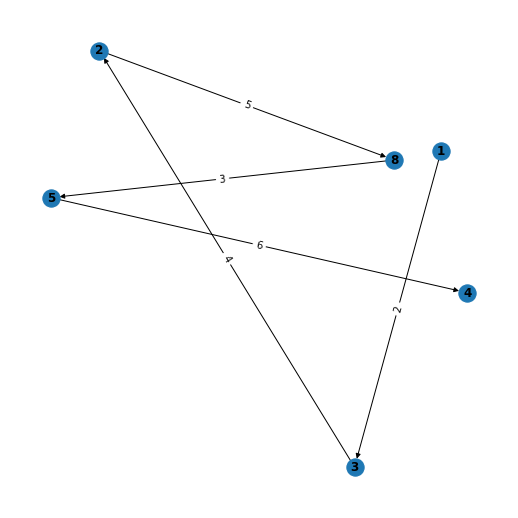

In [265]:
t2 = GRAPH()
t2.add_edge(from_n=1,to_n=3, time="438", w=2)
t2.add_edge(from_n=3,to_n=2, time="438", w=4)
t2.add_edge(from_n=2,to_n=8, time="438", w=5)
t2.add_edge(from_n=8,to_n=5, time="438", w=3)
t2.add_edge(from_n=5,to_n=4, time="438", w=6)
t2.add_node(6)
t2.print_graph()

In [266]:
    p = [1,3,2,8,5,4]
    final_path = []
    for i in range(0, len(p)-1):
        new_g, dist = dijkstra(p[i], t2)

        if(new_g.is_linked_from(p[i], p[i+1])):
            final_path.append(new_g.get_edge(p[i], p[i+1]))
        else:
            temp = []
            try:
                prec = [el for el in new_g.nodes[p[i+1]] if el.from_n != p[i+1]][0]
            except IndexError:
                print("Not possible")
                break

            temp.append(prec)

            while(not prec.from_n == p[i]):



                punt = [el for el in new_g.nodes[prec.from_n] if el.from_n != prec.from_n][0]

                temp.append(punt)

                prec = punt

            temp.reverse()
            final_path.extend(temp)
            
    
    lunghezza = sum([edge.w for edge in final_path])

    print(final_path)
    print(lunghezza)


[1 -> 3 ::::: weight = 2 ::::: time: 438, 3 -> 2 ::::: weight = 4 ::::: time: 438, 2 -> 8 ::::: weight = 5 ::::: time: 438, 8 -> 5 ::::: weight = 3 ::::: time: 438, 5 -> 4 ::::: weight = 6 ::::: time: 438]
20


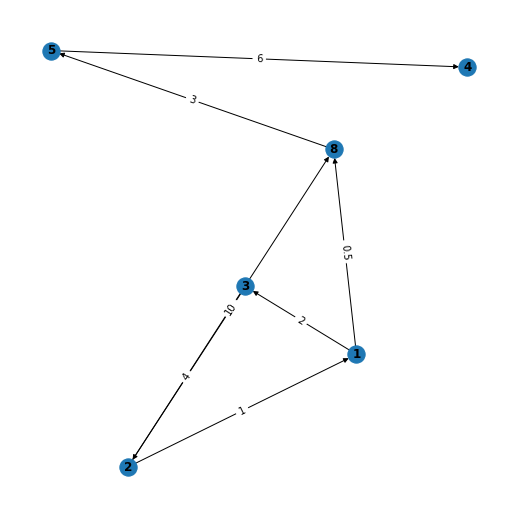

In [269]:
t2 = GRAPH()
t2.add_edge(from_n=1,to_n=3, time="438", w=2)
t2.add_edge(from_n=3,to_n=2, time="438", w=4)
t2.add_edge(from_n=2,to_n=8, time="438", w=10)
t2.add_edge(from_n=8,to_n=5, time="438", w=3)
t2.add_edge(from_n=5,to_n=4, time="438", w=6)
t2.add_edge(from_n=2,to_n=1, time="438", w=1)
t2.add_edge(from_n=1,to_n=8, time="438", w=0.5)
t2.add_node(6)
t2.print_graph()

In [270]:
    p = [1,3,2,8,5,4]
    final_path = []
    for i in range(0, len(p)-1):
        new_g, dist = dijkstra(p[i], t2)

        if(new_g.is_linked_from(p[i], p[i+1])):
            final_path.append(new_g.get_edge(p[i], p[i+1]))
        else:
            temp = []
            try:
                prec = [el for el in new_g.nodes[p[i+1]] if el.from_n != p[i+1]][0]
            except IndexError:
                print("Not possible")
                break

            temp.append(prec)

            while(not prec.from_n == p[i]):



                punt = [el for el in new_g.nodes[prec.from_n] if el.from_n != prec.from_n][0]

                temp.append(punt)

                prec = punt

            temp.reverse()
            final_path.extend(temp)
            
    
    lunghezza = sum([edge.w for edge in final_path])

    print(final_path)
    print(lunghezza)


[1 -> 3 ::::: weight = 2 ::::: time: 438, 3 -> 2 ::::: weight = 4 ::::: time: 438, 2 -> 1 ::::: weight = 1 ::::: time: 438, 1 -> 8 ::::: weight = 1.5 ::::: time: 438, 8 -> 5 ::::: weight = 3 ::::: time: 438, 5 -> 4 ::::: weight = 6 ::::: time: 438]
17.5


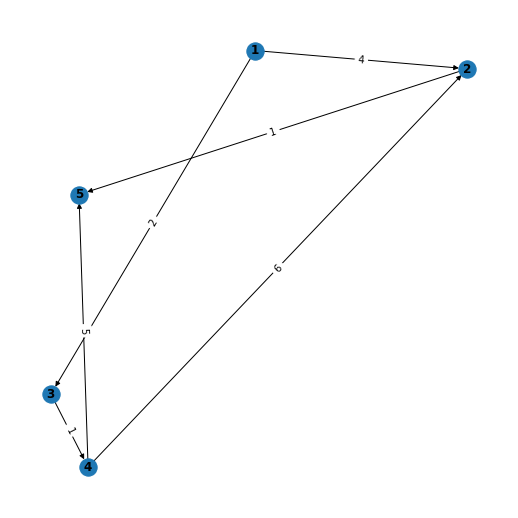

In [271]:
t2 = GRAPH()
t2.add_edge(from_n=1,to_n=3, time="438", w=2)
t2.add_edge(from_n=1,to_n=2, time="438", w=4)
t2.add_edge(from_n=3,to_n=4, time="438", w=1)
t2.add_edge(from_n=4,to_n=2, time="438", w=6)
t2.add_edge(from_n=2,to_n=5, time="438", w=1)
t2.add_edge(from_n=4,to_n=5, time="438", w=5)
t2.add_node(6)
t2.print_graph()

In [272]:
    p = [1,2,6]
    final_path = []
    for i in range(0, len(p)-1):
        new_g, dist = dijkstra(p[i], t2)

        if(new_g.is_linked_from(p[i], p[i+1])):
            final_path.append(new_g.get_edge(p[i], p[i+1]))
        else:
            temp = []
            try:
                prec = [el for el in new_g.nodes[p[i+1]] if el.from_n != p[i+1]][0]
            except IndexError:
                print("Not possible")
                break

            temp.append(prec)

            while(not prec.from_n == p[i]):



                punt = [el for el in new_g.nodes[prec.from_n] if el.from_n != prec.from_n][0]

                temp.append(punt)

                prec = punt

            temp.reverse()
            final_path.extend(temp)
            
    
    lunghezza = sum([edge.w for edge in final_path])

    print(final_path)
    print(lunghezza)


Not possible
[1 -> 2 ::::: weight = 4 ::::: time: 438]
4


In [274]:
    p = [1,2,5]
    final_path = []
    for i in range(0, len(p)-1):
        new_g, dist = dijkstra(p[i], t2)

        if(new_g.is_linked_from(p[i], p[i+1])):
            final_path.append(new_g.get_edge(p[i], p[i+1]))
        else:
            temp = []
            try:
                prec = [el for el in new_g.nodes[p[i+1]] if el.from_n != p[i+1]][0]
            except IndexError:
                print("Not possible")
                break

            temp.append(prec)

            while(not prec.from_n == p[i]):



                punt = [el for el in new_g.nodes[prec.from_n] if el.from_n != prec.from_n][0]

                temp.append(punt)

                prec = punt

            temp.reverse()
            final_path.extend(temp)
            
    
    lunghezza = sum([edge.w for edge in final_path])

    print(final_path)
    print(lunghezza)


[1 -> 2 ::::: weight = 4 ::::: time: 438, 2 -> 5 ::::: weight = 1 ::::: time: 438]
5
